In [120]:
import ROOT
from ROOT import TCanvas, TPad, TFile, TPaveLabel, TPaveText, TH1F, TH2F
from ROOT import gROOT, gBenchmark, gRandom, gSystem, RDataFrame

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle

## Loading Data

In [73]:
data = RDataFrame("t;1", "FullSim_E5GeV.root").AsNumpy()

In [74]:
X = np.array(
    [
        data["part_p"],
        data["part_x"], 
        data["part_y"],
        data["part_z"],
        data["part_theta"],
        data["part_phi"]
    ]
).transpose()
obs = data["cl_E_ecal"]
del data

## Subsetting Data

We apply some cuts on each coordinate:
- 500 < x < 3500
- 500 < y < 2500
- 12280 < z < 12300
- $\theta$ < 0.6
- $\phi$ < 2$\pi$

In [75]:
subset = (X.transpose()[1]>500) \
            *(X.transpose()[1]<3500) \
            *(X.transpose()[2]>500) \
            *(X.transpose()[2]<2500) \
            *(X.transpose()[3]>12280) \
            *(X.transpose()[3]<12300) \
            *(X.transpose()[4]<0.6) \
            *(X.transpose()[5]<2*np.pi) \
    
X_sel, obs = X[subset], obs[subset]
del X

## Data Processing

### Step 1: Make data into a 2-d greyscale image
The `make_img` function takes 3 arguments:
- `data`: should be an array of data points with these entries $(p,x,y,z,\theta,\phi)$
- `obs`: For each data point the corresponding $E_{\text{clust}}$
- `params`: details for axis ranges and resolution for binning

For example: 

```
{
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (-1,0.05),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
}

```
`make_img` takes our FullSim data and bins it along the range and with the resolution specified for each axis in `params`. By setting the `reso` property to `None` we choose not to bin along that axis. The function returns an array where each axis corresponds to a binned feature. Each entry is the mean for the given bin. 

### Step 2: Apply a Fourier Transform mask to the data

The `fft_filter` function takes 4 arguments:
- `data`: `np.ndarray` type object produce by `make_img`
- `n_sigma`: number of standard deviations for signal filtering step (default = `3`)
- `make_plots`: whether to plot a comparison of the image before filter and after filter (default = `False`)
-  `make_sparse`: whether to only return the points and indices of data points passing the signal filter (default = `False`)

`fft_filter` applies a n-dimensional Fourier transform across all $n$ dimensions of `data`. Then based on the threshold set by `n_sigma`, it discards the weak signals. The idea is that when we set `make_sparse = True` we will only have to store less than ca. $n\cdot1000$ data points to reconstruct the calorimeter non-uniformities in $n$ dimensions. 


In [109]:
def make_img(data, obs, params):
    ind_map = {
        "X": 1,
        "Y": 2,
        "theta": 4,
        "phi": 5
    }
    
    print(f"[1/2] binning data...")
    data = data.transpose()
    subset = (data[1] > params["X"]["range"][0])*(data[1] < params["X"]["range"][1])* \
             (data[2] > params["Y"]["range"][0])*(data[2] < params["Y"]["range"][1])* \
             (data[4] > params["theta"]["range"][0])*(data[4] < params["theta"]["range"][1])* \
             (data[5] > params["phi"]["range"][0])*(data[5] < params["phi"]["range"][1])
    data = data.transpose()[subset].transpose()
    binned_data = {"E": obs[subset]}
    for key in tqdm(params.keys()):
        if params[key]["reso"]:
            bins = data[ind_map[key]]*params[key]["reso"]
            binned_data[key] = bins.astype('int')
    print("[2/2] creating image...")
    df = pd.DataFrame(binned_data)
    df_binned =  df.groupby(list(binned_data.keys())[1:]).mean()
    E_by_bin = np.array(df_binned.E)
    return E_by_bin.reshape([int(max(binned_data[key]) - min(binned_data[key])+1) for key in list(binned_data.keys())[1:]])

def fft_filter(data, n_sigma = 3, make_plots = False, make_sparse = False):
    print(f"[1/2] performing fast Fourier transform along {len(data.shape)} axes...")
    data_fft = np.fft.fftn(data)
    cutoff = np.mean(np.log(abs(data_fft.flatten()))) + n_sigma*np.std(np.log(abs(data_fft.flatten())))
    print(f"[2/2] filtering Fourier transformed data with cutoff e^{cutoff}")
    if make_sparse:
        saved_points = []
        for index, E in tqdm(np.ndenumerate(data_fft)):
            if np.log(abs(E)) > cutoff:
                saved_points.append((index, E))
        return saved_points
    else:    
        for index, E in tqdm(np.ndenumerate(data_fft)):
            if np.log(abs(E)) < cutoff:
                data_fft[index] = 1 + 0j
            else:
                data_fft[index] = E
    if make_plots:
        print("Data before FFT and filtering:")
        plt.figure(figsize=(12,8))
        plt.imshow(data, cmap='gray', origin="lower")
        plt.show()
        print("Data after FFT and filtering:")
        plt.figure(figsize=(12,8))
        plt.imshow(abs(np.fft.ifftn(data_fft)), cmap='gray', origin="lower")
        plt.show()
    return data_fft

In [168]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.05),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
data_binned = make_img(X_sel, obs, params)

[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 337.01it/s]


[2/2] creating image...
              E
X              
50   666.628601
51   669.756592
52   670.786621
53   670.233643
54   671.379150
..          ...
345  662.999512
346  663.121155
347  663.222412
348  663.571228
349  662.642395

[300 rows x 1 columns]


Here is an example of the `fft_filter` function in action. The top plot shows the binned data and the bottom plot shows the data after filtering.

[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^8.396987305207738


60000it [00:00, 1638048.08it/s]

Data before FFT and filtering:


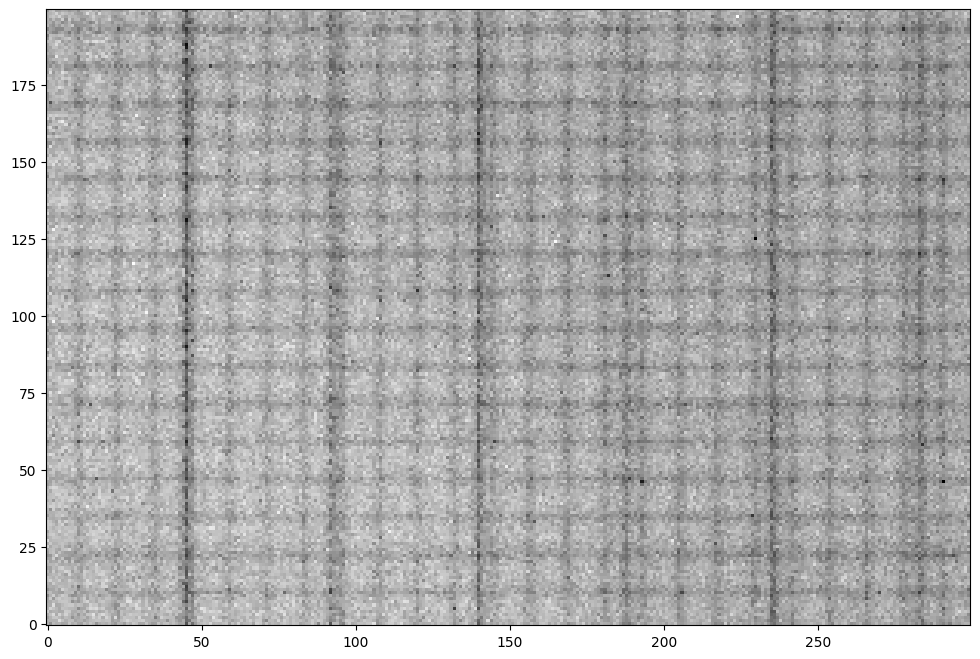

Data after FFT and filtering:


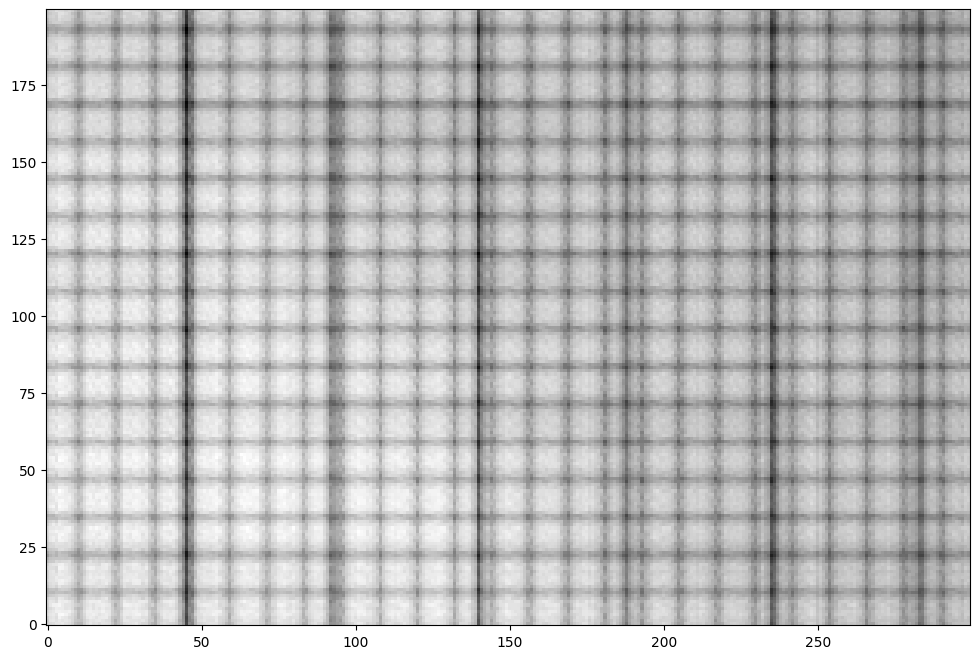

In [11]:
fft_filt = fft_filter(data_binned, n_sigma = 2, make_plots=True)

## Pairwise Fourier analysis approach

Here my idea is we compute the fourier transform filtered signal across each pair of dimensions, and then for a given coordinate we either average between the ${4 \choose 2} = 6$ signals, or we can use some kind of ML to give a prediction based on the signals. 

So given a data points $(x,y,z,\theta,\phi)$ we first find the associated bin for the data point and for that bin we take the corresponding coordinate combination and calculate their average.

In [7]:
params_pairwise = {
    "X_v_Y": {
        "X": {
            "range": (500,3500),
            "reso": 0.1
        }, 
        "Y": {
            "range": (500,2500),
            "reso": 0.1
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": None
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": None
        }
    },
    "X_v_theta": {
        "X": {
            "range": (500,3500),
            "reso": 0.1
        }, 
        "Y": {
            "range": (500,2500),
            "reso": None
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": 100
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": None
        }
    },
    "X_v_phi": {
        "X": {
            "range": (500,3500),
            "reso": 0.1
        }, 
        "Y": {
            "range": (500,2500),
            "reso": None
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": None
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": 10
        }
    },
    "Y_v_theta": {
        "X": {
            "range": (500,3500),
            "reso": None
        }, 
        "Y": {
            "range": (500,2500),
            "reso": 0.1
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": 100
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": None
        }
    },
    "Y_v_phi": {
        "X": {
            "range": (500,3500),
            "reso": None
        }, 
        "Y": {
            "range": (500,2500),
            "reso": 0.1
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": None
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": 10
        }
    },
    "theta_v_phi": {
        "X": {
            "range": (500,3500),
            "reso": None
        }, 
        "Y": {
            "range": (500,2500),
            "reso": None
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": 100
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": 10
        }
    }
}

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.89it/s]


[2/2] creating image...
                  E
X   Y              
50  50   662.248108
    51   658.741882
    52   652.172974
    53   661.334290
    54   662.379883
...             ...
349 245  654.031006
    246  651.570312
    247  654.323975
    248  653.406738
    249  656.205017

[60000 rows x 1 columns]
Plotting X_v_Y
X range is (500, 3500)
X bin scaling is 10.0
Y range is (500, 2500)
Y bin scaling is 10.0
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^7.213276420370341


60000it [00:00, 1791098.11it/s]

Data before FFT and filtering:


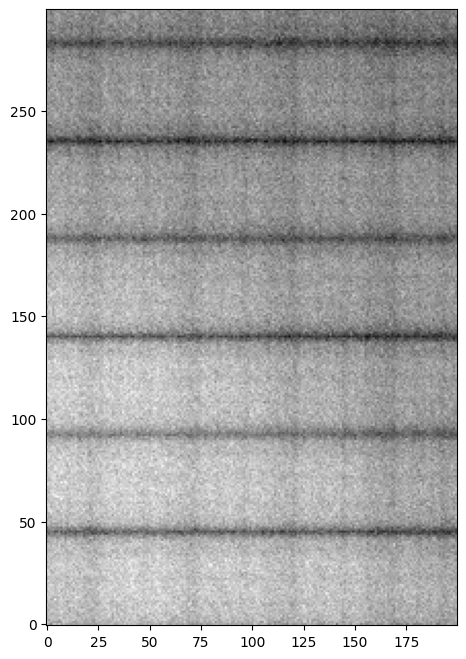

Data after FFT and filtering:


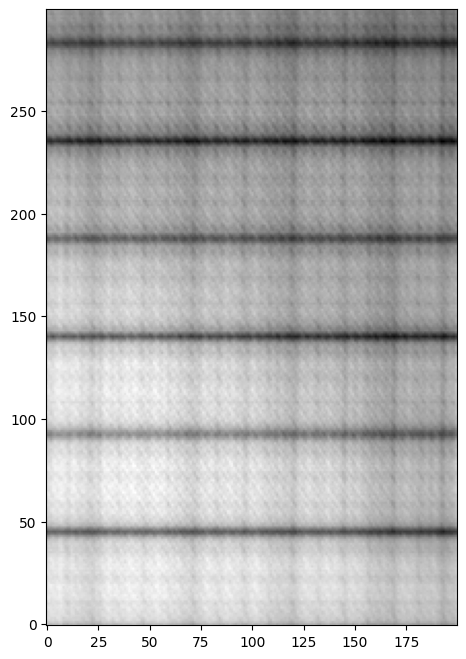

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.30it/s]


[2/2] creating image...
                    E
X   theta            
50  0      668.393616
    1      667.823975
    2      664.987427
    3      666.200195
    4      665.632996
...               ...
349 55     639.827454
    56     638.310852
    57     635.496460
    58     635.227783
    59     632.961121

[18000 rows x 1 columns]
Plotting X_v_theta
X range is (500, 3500)
X bin scaling is 10.0
theta range is (0, 0.6)
theta bin scaling is 0.01
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.467335743316882


18000it [00:00, 1723175.13it/s]

Data before FFT and filtering:


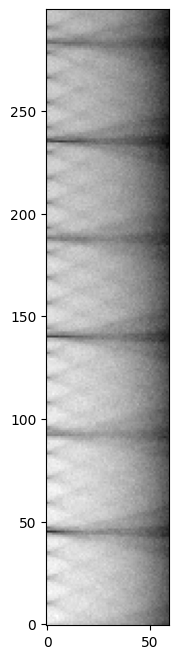

Data after FFT and filtering:


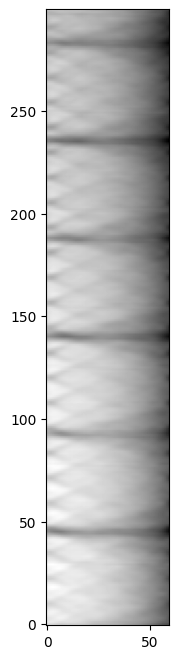

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.70it/s]


[2/2] creating image...
                  E
X   phi            
50  0    663.634827
    1    662.227783
    2    661.014038
    3    662.059448
    4    660.959229
...             ...
349 58   650.983521
    59   652.699463
    60   653.049316
    61   650.674011
    62   654.053101

[18900 rows x 1 columns]
Plotting X_v_phi
X range is (500, 3500)
X bin scaling is 10.0
phi range is (0, 6.283185307179586)
phi bin scaling is 0.1
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.61287411330999


18900it [00:00, 1768169.55it/s]

Data before FFT and filtering:


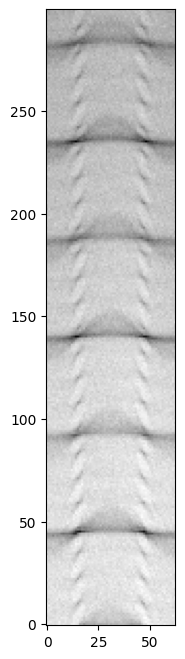

Data after FFT and filtering:


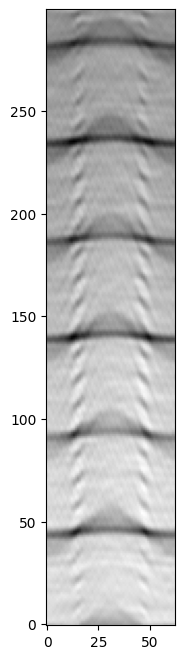

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.46it/s]


[2/2] creating image...
                    E
Y   theta            
50  0      667.370300
    1      667.139526
    2      666.868469
    3      665.110413
    4      664.874023
...               ...
249 55     639.099670
    56     639.078857
    57     639.023499
    58     637.069031
    59     635.318054

[12000 rows x 1 columns]
Plotting Y_v_theta
Y range is (500, 2500)
Y bin scaling is 10.0
theta range is (0, 0.6)
theta bin scaling is 0.01
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.010137629600004


12000it [00:00, 1900239.66it/s]

Data before FFT and filtering:


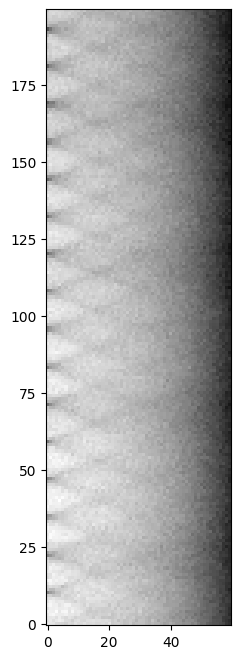

Data after FFT and filtering:


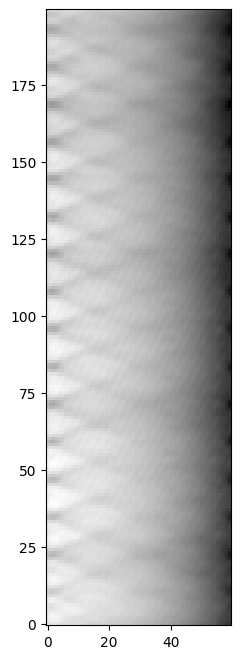

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 30.55it/s]


[2/2] creating image...
                  E
Y   phi            
50  0    660.322021
    1    659.669678
    2    659.495728
    3    659.240295
    4    659.595764
...             ...
249 58   654.752075
    59   653.841125
    60   654.834717
    61   656.781494
    62   656.667358

[12600 rows x 1 columns]
Plotting Y_v_phi
Y range is (500, 2500)
Y bin scaling is 10.0
phi range is (0, 6.283185307179586)
phi bin scaling is 0.1
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.007172282769744


12600it [00:00, 1811918.62it/s]

Data before FFT and filtering:


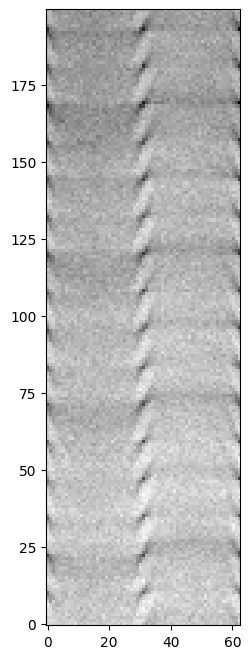

Data after FFT and filtering:


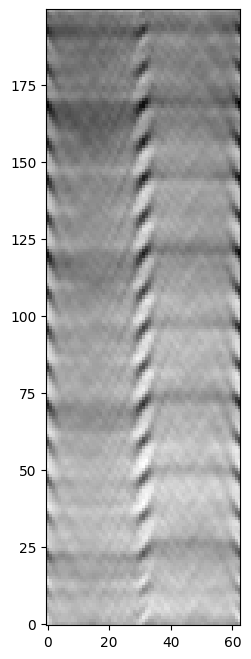

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 32.03it/s]


[2/2] creating image...
                    E
theta phi            
0     0    663.686707
      1    664.163879
      2    664.097717
      3    663.864685
      4    664.415649
...               ...
59    58   637.653015
      59   639.524902
      60   637.565125
      61   637.632141
      62   636.503662

[3780 rows x 1 columns]
Plotting theta_v_phi
theta range is (0, 0.6)
theta bin scaling is 0.01
phi range is (0, 6.283185307179586)
phi bin scaling is 0.1
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^4.897568270871723


3780it [00:00, 1826972.70it/s]

Data before FFT and filtering:


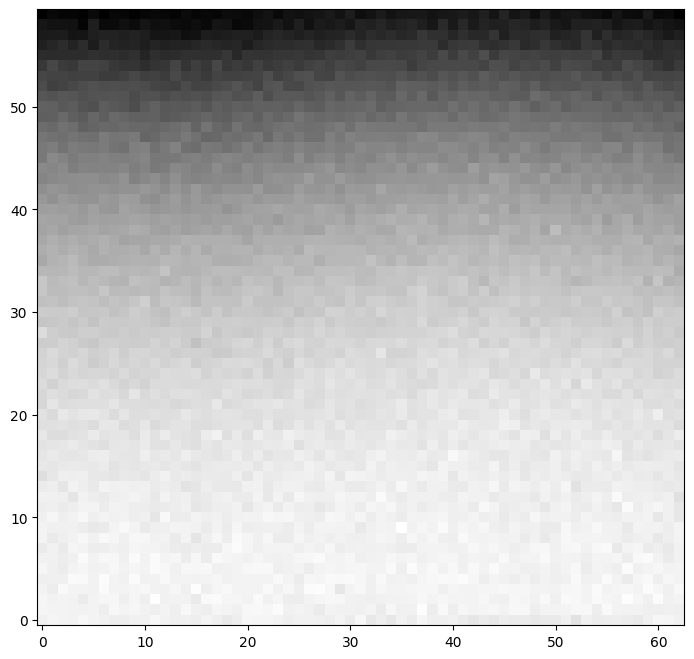

Data after FFT and filtering:


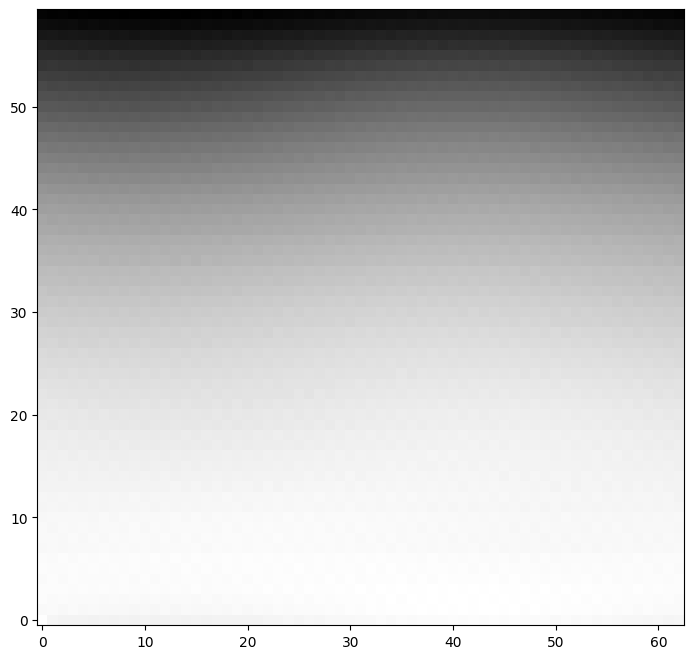

In [121]:
fft_filt_pw = {}
for key in params_pairwise.keys():
    data_binned = make_img(X_sel, obs, params_pairwise[key])
    print(f"Plotting {key}")
    print(f"{key.split("_")[0]} range is {params_pairwise[key][key.split("_")[0]]["range"]}")
    print(f"{key.split("_")[0]} bin scaling is {1/params_pairwise[key][key.split("_")[0]]["reso"]}")
    print(f"{key.split("_")[2]} range is {params_pairwise[key][key.split("_")[2]]["range"]}")
    print(f"{key.split("_")[2]} bin scaling is {1/params_pairwise[key][key.split("_")[2]]["reso"]}")
    fft_filt_pw[key] = fft_filter(data_binned, n_sigma = 2, make_plots=True)

In [15]:
ind_map = {
        "X": 1,
        "Y": 2,
        "theta": 4,
        "phi": 5,
        1: "X",
        2: "Y",
        4: "theta",
        5: "phi"
    }

ifft_filt_pw = {key: abs(np.fft.ifftn(fft_filt_pw[key])) for key in fft_filt_pw.keys()}

In [16]:
ind_map = {
        "X": 1,
        "Y": 2,
        "theta": 4,
        "phi": 5,
        1: "X",
        2: "Y",
        4: "theta",
        5: "phi"
    }

In [17]:
ifft_filt_pw = {key: abs(np.fft.ifftn(fft_filt_pw[key])) for key in fft_filt_pw.keys()}

In [18]:
ifft_inputs = []
for row in tqdm(X_sel):
    ifft_row = []
    for key in ifft_filt_pw.keys():
        var_1 = (key.split("_")[0], ind_map[key.split("_")[0]])
        var_2 = (key.split("_")[2], ind_map[key.split("_")[2]])
        coordinates_scaled = (
            int((row[var_1[1]]-params_pairwise[key][var_1[0]]["range"][0])*params_pairwise[key][var_1[0]]["reso"]), 
            int((row[var_2[1]]-params_pairwise[key][var_2[0]]["range"][0])*params_pairwise[key][var_2[0]]["reso"])
        )
        ifft_val = ifft_filt_pw[key][coordinates_scaled[1], coordinates_scaled[0]]
        ifft_row.append(ifft_val)
    ifft_inputs.append(ifft_row)

100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [13:22<00:00, 63630.00it/s]


In [19]:
ifft_inputs = np.array(ifft_inputs)

In [20]:
ifft_avgs = np.apply_along_axis(np.mean, 1, ifft_inputs)

In [23]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (-1,0.05),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
data_binned = make_img(X_sel, obs, params)
ifft_data_binned = make_img(X_sel, ifft_avgs, params)

[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 402.42it/s]


[2/2] creating image...
[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 409.13it/s]


[2/2] creating image...


## Gut Check: Does this work?

We can try to replicate the plot we had in the Data-Preprocessing section using our coordinate-pairwise fourier signal filtering method. The first image shows the data from the FullSim and the second image is the result from average across the signal from each coordinate pair. 


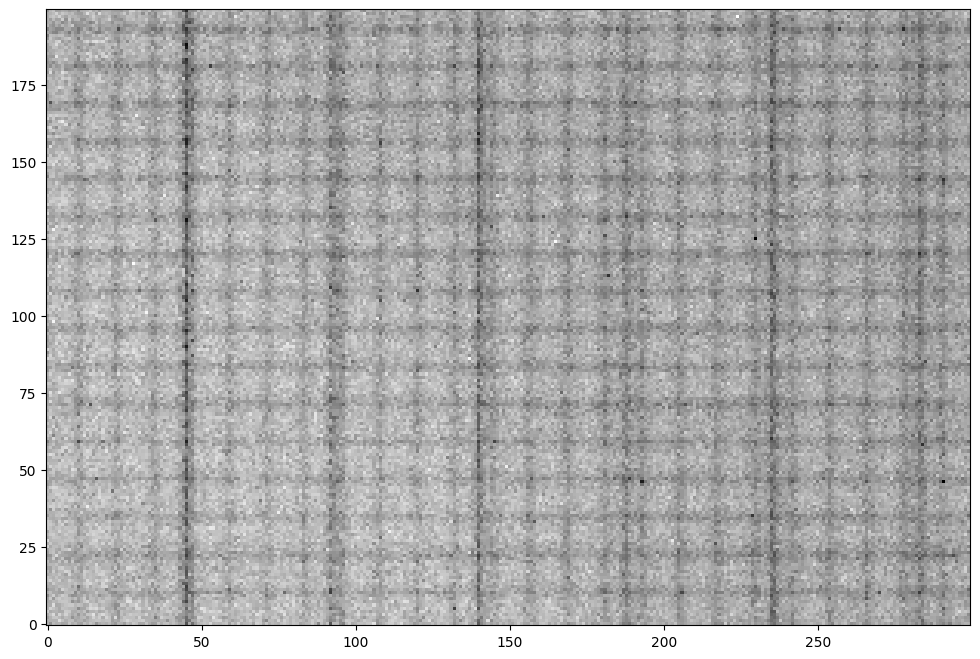

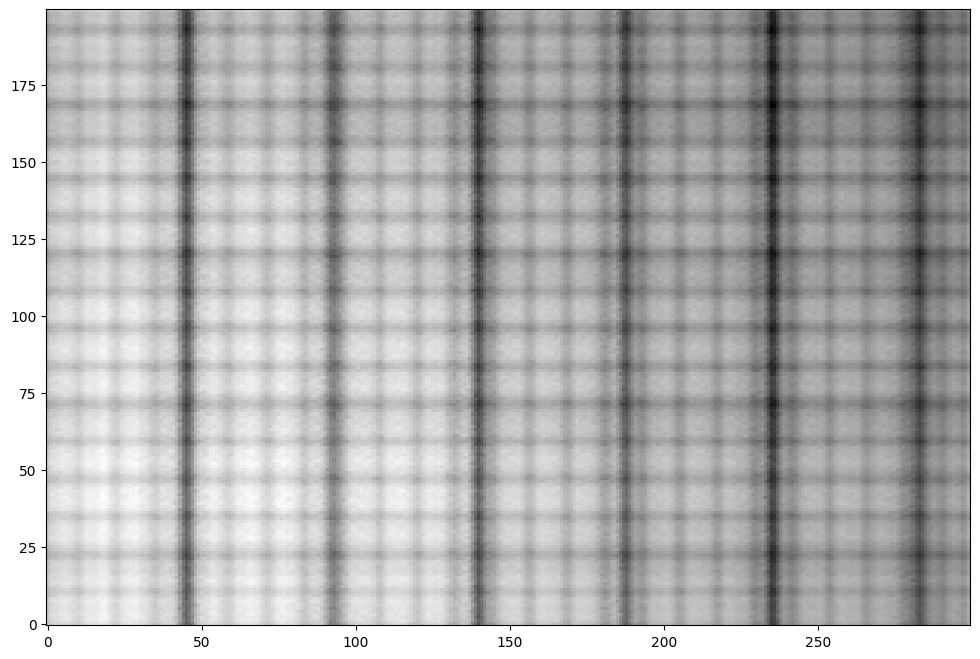

In [24]:
plt.figure(figsize=(12,8))
plt.imshow(data_binned, cmap='gray', origin="lower")
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(ifft_data_binned, cmap='gray', origin="lower")
plt.show()

In [128]:
fft_filt_pw = {}
for key in params_pairwise.keys():
    data_binned = make_img(X_sel, obs, params_pairwise[key])
    print(f"Plotting {key}")
    print(f"{key.split("_")[0]} range is {params_pairwise[key][key.split("_")[0]]["range"]}")
    print(f"{key.split("_")[0]} bin scaling is {1/params_pairwise[key][key.split("_")[0]]["reso"]}")
    print(f"{key.split("_")[2]} range is {params_pairwise[key][key.split("_")[2]]["range"]}")
    print(f"{key.split("_")[2]} bin scaling is {1/params_pairwise[key][key.split("_")[2]]["reso"]}")
    fft_filt_pw[key] = fft_filter(data_binned, n_sigma = 2, make_sparse=True)

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.99it/s]


[2/2] creating image...
                  E
X   Y              
50  50   662.248108
    51   658.741882
    52   652.172974
    53   661.334290
    54   662.379883
...             ...
349 245  654.031006
    246  651.570312
    247  654.323975
    248  653.406738
    249  656.205017

[60000 rows x 1 columns]
Plotting X_v_Y
X range is (500, 3500)
X bin scaling is 10.0
Y range is (500, 2500)
Y bin scaling is 10.0
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^7.213276420370341


60000it [00:00, 2059244.74it/s]

[1/2] binning data...



100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.18it/s]


[2/2] creating image...
                    E
X   theta            
50  0      668.393616
    1      667.823975
    2      664.987427
    3      666.200195
    4      665.632996
...               ...
349 55     639.827454
    56     638.310852
    57     635.496460
    58     635.227783
    59     632.961121

[18000 rows x 1 columns]
Plotting X_v_theta
X range is (500, 3500)
X bin scaling is 10.0
theta range is (0, 0.6)
theta bin scaling is 0.01
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.467335743316882


18000it [00:00, 1990914.59it/s]

[1/2] binning data...



100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 34.40it/s]


[2/2] creating image...
                  E
X   phi            
50  0    663.634827
    1    662.227783
    2    661.014038
    3    662.059448
    4    660.959229
...             ...
349 58   650.983521
    59   652.699463
    60   653.049316
    61   650.674011
    62   654.053101

[18900 rows x 1 columns]
Plotting X_v_phi
X range is (500, 3500)
X bin scaling is 10.0
phi range is (0, 6.283185307179586)
phi bin scaling is 0.1
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.61287411330999


18900it [00:00, 1596687.59it/s]

[1/2] binning data...



100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.59it/s]


[2/2] creating image...
                    E
Y   theta            
50  0      667.370300
    1      667.139526
    2      666.868469
    3      665.110413
    4      664.874023
...               ...
249 55     639.099670
    56     639.078857
    57     639.023499
    58     637.069031
    59     635.318054

[12000 rows x 1 columns]
Plotting Y_v_theta
Y range is (500, 2500)
Y bin scaling is 10.0
theta range is (0, 0.6)
theta bin scaling is 0.01
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.010137629600004


12000it [00:00, 2046334.69it/s]

[1/2] binning data...



100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.15it/s]


[2/2] creating image...
                  E
Y   phi            
50  0    660.322021
    1    659.669678
    2    659.495728
    3    659.240295
    4    659.595764
...             ...
249 58   654.752075
    59   653.841125
    60   654.834717
    61   656.781494
    62   656.667358

[12600 rows x 1 columns]
Plotting Y_v_phi
Y range is (500, 2500)
Y bin scaling is 10.0
phi range is (0, 6.283185307179586)
phi bin scaling is 0.1
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.007172282769744


12600it [00:00, 2046160.38it/s]

[1/2] binning data...



100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.88it/s]


[2/2] creating image...
                    E
theta phi            
0     0    663.686707
      1    664.163879
      2    664.097717
      3    663.864685
      4    664.415649
...               ...
59    58   637.653015
      59   639.524902
      60   637.565125
      61   637.632141
      62   636.503662

[3780 rows x 1 columns]
Plotting theta_v_phi
theta range is (0, 0.6)
theta bin scaling is 0.01
phi range is (0, 6.283185307179586)
phi bin scaling is 0.1
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^4.897568270871723


3780it [00:00, 2069233.77it/s]


In [161]:
def reconstruct_img(sparse_data, shape, apply_ifft=False):
    a = np.ones(shape, dtype='complex')
    for e in sparse_data:
        a[e[0]] = e[1]
    if apply_ifft:
        a = abs(np.fft.ifftn(a))
    return a

def complete_data_pw(data, params_pairwise):
    completed_data = {}
    for key in data:
        var1 = key.split("_")[0]
        var2 = key.split("_")[2]
        var1_min= min([data[key][i][0][0] for i in range(len(data[key]))])
        var2_min= min([data[key][i][0][1] for i in range(len(data[key]))])
        var1_max= max([data[key][i][0][0] for i in range(len(data[key]))])
        var2_max= max([data[key][i][0][1] for i in range(len(data[key]))])
        print(var1_max- var1_min)
        completed_data[key] = reconstruct_img(data[key], (var1_max - var1_min+1, var2_max- var2_min+1))
    return completed_data

In [163]:
test = complete_data_pw(fft_filt_pw, params_pairwise)

299
299
299
199
199
59


In [141]:
test

array([[654.20444965, 653.41304173, 653.08779284, ..., 649.76996762,
        649.90495301, 651.27585618],
       [654.22607881, 654.87250162, 655.28716949, ..., 651.9222242 ,
        651.76865936, 652.53696447],
       [655.23114   , 656.25923145, 656.07308408, ..., 652.41065316,
        652.39470938, 653.14792245],
       ...,
       [648.78709509, 649.3786966 , 647.99269164, ..., 644.83215385,
        645.15078103, 646.3807284 ],
       [649.18743857, 649.71809702, 648.51218005, ..., 645.83837317,
        645.36181421, 646.93123641],
       [650.04287904, 650.39237636, 649.63822962, ..., 646.68211057,
        646.0488244 , 647.51914648]])

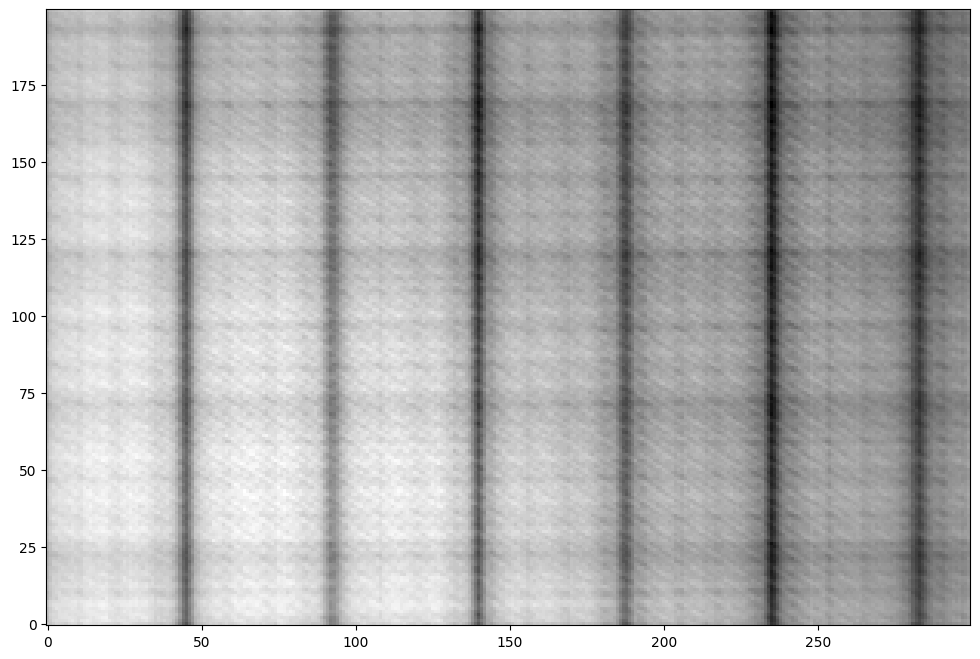

In [164]:
plt.figure(figsize=(12,8))
plt.imshow(abs(np.fft.ifftn(test["X_v_Y"])).transpose(), cmap='gray', origin="lower")
plt.show()

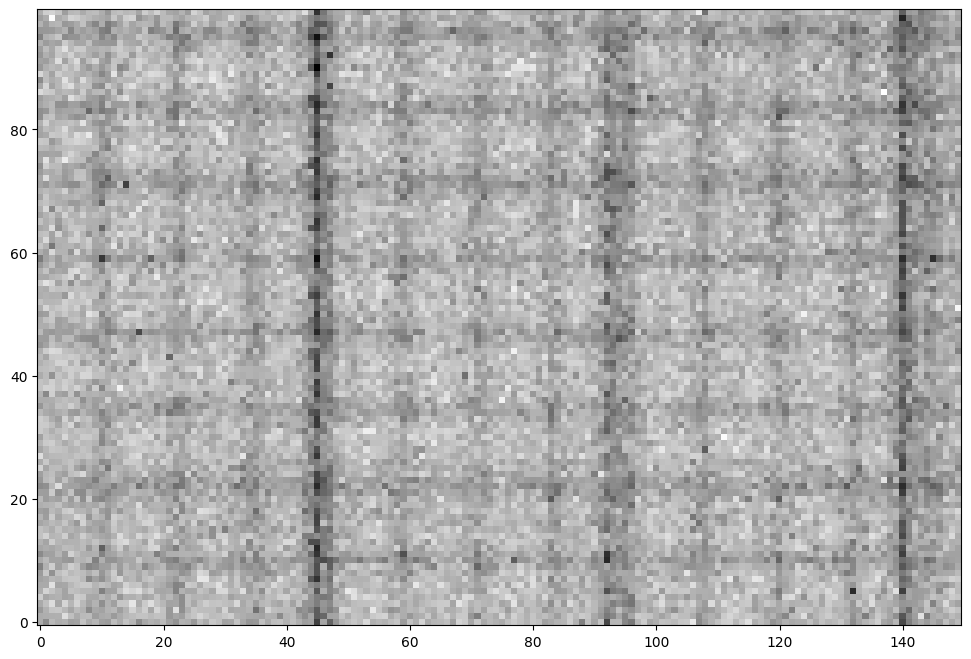

In [167]:
plt.figure(figsize=(12,8))
plt.imshow(data_binned[:150,:100].transpose(), cmap='gray', origin="lower")
plt.show()

In [29]:
data_sparse

[((0, 0), (7880276.86907959+0j)),
 ((0, 1), (-18418.691769596757-45358.423950284705j)),
 ((0, 2), (-3154.318761057052-24889.520724100563j)),
 ((0, 3), (-32.54548592610771-16981.62541158153j)),
 ((0, 4), (1090.0190358882624-12627.219050122105j)),
 ((0, 5), (1575.2997919831985-10139.70274059919j)),
 ((0, 6), (1882.2489501111518-8420.973713005085j)),
 ((0, 7), (2054.3781318578312-7076.584486401314j)),
 ((0, 8), (2174.6255836995424-6117.468478578663j)),
 ((0, 9), (2342.352370674127-5291.50266198706j)),
 ((0, 10), (2383.289031982422-4552.66536577917j)),
 ((0, 11), (2369.258275322498-4079.2201376191947j)),
 ((0, 12), (2474.3011792968136-3709.9508390134924j)),
 ((0, 13), (2506.062441225533-3255.032367436228j)),
 ((0, 14), (2472.6253020598924-2985.2696545265317j)),
 ((0, 15), (2454.6417846679688-2700.8094482421875j)),
 ((0, 16), (2479.2312111133406-2388.4374520389188j)),
 ((0, 17), (2406.628313908703-2090.836336073924j)),
 ((0, 18), (2568.0222290880674-1949.7169003545498j)),
 ((0, 19), (2545.1

In [62]:
data = RDataFrame("t;1", "FullSim_E5GeV.root").AsNumpy()

In [63]:
X = np.array(
    [
        data["part_p"],
        data["part_x"], 
        data["part_y"],
        data["part_z"],
        data["part_theta"],
        data["part_phi"]
    ]
).transpose()
obs = data["cl_E_ecal"]
del data

In [64]:
subset = (X.transpose()[1]>500) \
            *(X.transpose()[1]<3500) \
            *(X.transpose()[2]>500) \
            *(X.transpose()[2]<2500) \
            *(X.transpose()[3]>12280) \
            *(X.transpose()[3]<12300) \
            *(X.transpose()[4]<0.6) \
            *(X.transpose()[5]<2*np.pi) \
    
X_sel, obs = X[subset], obs[subset]
del X

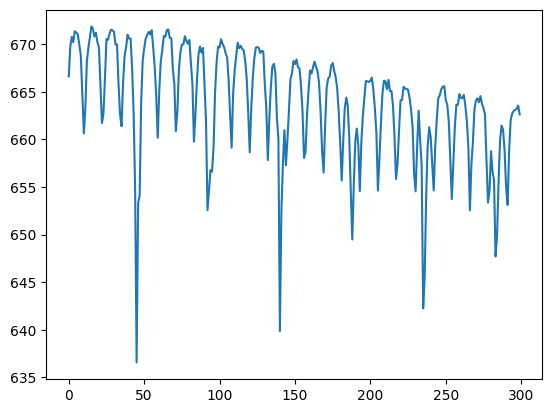

In [170]:
plt.plot(data_binned)